In [1]:
# created by Shivank Goel
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import pinv as inv
from numpy.linalg import norm as norm

In [2]:
np.random.seed(1234)

def rand_cond_mat(m,s):
    X = np.random.randn(m,6)
    X[:, 2] = X[:, 0] + 3 * X[:, 1] + np.random.randn(m) / s
    X[:, 5] = X[:, 3] + 5 * X[:, 4] + np.random.randn(m) / s
    X = np.column_stack((X,np.ones(m)))
    s = np.linalg.svd(X,compute_uv = False)
    X = X/s[0]
    return X

m = 100
scales = [10**i for i in range(1,8)]
As = np.array([rand_cond_mat(m, s) for s in scales])
r = 1e-1 * np.random.randn(m)
xtrue = np.random.randn(As.shape[2])
bs = [A @ xtrue + r for A in As]

In [3]:
def ls_bs(A,b):
    return inv(A)@b

def ls_qr(A,b):
    Q,R = np.linalg.qr(A)
    return inv(R) @ Q.T @ b

def ls_svd(A,b):
    U,S,V_T = np.linalg.svd(A, full_matrices= False)
    return V_T.T @ inv(np.diag(S)) @ U.T @ b

def ls_chol(A,b):
    L = np.linalg.cholesky(A.T @ A)
    return inv(L).T @ inv(L) @ A.T @ b

In [4]:
xhat_bs   = [ls_bs(A, b) for (A, b) in zip(As, bs)]
xhat_chol = [ls_chol(A, b) for (A, b) in zip(As, bs)]
xhat_qr   = [ls_qr(  A, b) for (A, b) in zip(As, bs)]
xhat_svd  = [ls_svd( A, b) for (A, b) in zip(As, bs)]

In [5]:
ntrue = norm(xtrue)
bs_diff   = [norm(x - xtrue) / ntrue for x in xhat_bs]
chol_diff = [norm(x - xtrue) / ntrue for x in xhat_chol]
qr_diff   = [norm(x - xtrue) / ntrue for x in xhat_qr]
svd_diff  = [norm(x - xtrue) / ntrue for x in xhat_svd]

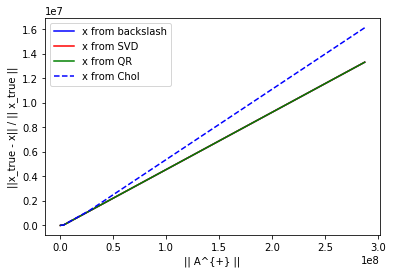

In [6]:
conds = [norm(inv(A),2) for A in As]
plt.plot(conds,  bs_diff, 'b-', label="x from backslash")
plt.plot(conds, svd_diff, 'r-',   label="x from SVD")
plt.plot(conds, qr_diff, 'g-', label="x from QR")
plt.plot(conds, chol_diff, 'b--',  label="x from Chol")
plt.xlabel("|| A^{+} ||")
plt.ylabel("||x_true - x|| / || x_true ||")
plt.legend(loc = "best")

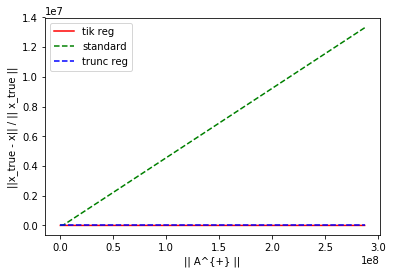

In [8]:
# Tikhonov regularization
def ls_svd_tik(A,b,l):
    U, S, V = np.linalg.svd(A,full_matrices= False)
    S = [s/(s*s+ l*l) for s in S]
    return V @ inv(np.diag(S)) @ U.T @ b

def ls_svd_trunc(A,b,e):
    U, S, V = np.linalg.svd(A,full_matrices= False)
    k = next((i for i,x in enumerate(S) if x<e), None)
    k = len(S) if k == None else (k+1)
    return V[:,:k] @ inv(np.diag(S[:k])) @ U[:,:k].T @ b

l = 0.001
e = np.linalg.svd(As[0],compute_uv = False)[4] * (1 + 1e-8)
xhat_svd_tik  = [ls_svd_tik(A, b, l) for (A, b) in zip(As, bs)]
svd_tik_diff  = [norm(x - xtrue) / ntrue for x in xhat_svd_tik]
xhat_svd_trunc  = [ls_svd_trunc(A, b, e) for (A, b) in zip(As, bs)]
svd_trunc_diff  = [norm(x - xtrue) / ntrue for x in xhat_svd_trunc]
plt.plot(conds,  svd_tik_diff,'r-', label="tik reg")
plt.plot(conds, svd_diff,  'g--' , label="standard")
plt.plot(conds, svd_trunc_diff,  'b--' , label="trunc reg")
plt.xlabel("|| A^{+} ||")
plt.ylabel("||x_true - x|| / || x_true ||")
plt.legend(loc = "best")

In [10]:
from sklearn import linear_model
def lasso_solve(A,b,l):
    model = linear_model.Lasso(alpha=l,fit_intercept = False)
    model.fit(A,b)
    return model.coef_

for xhat_lasso in [lasso_solve(A, b, 0.00001) for (A, b) in zip(As, bs)]:
    print(xhat_lasso)

[-0.11784731 -0.          1.86287445  1.64158612  0.          0.32679042
  1.42740041]
[ 1.40107877  0.          1.36376448  1.06938847 -0.          0.30274424
  1.06258559]
[-0.          0.          1.77767265  0.35049377  0.          0.24106619
  1.28017912]
[0.97744932 0.         1.46017489 1.07306872 0.         0.25262986
 1.34576903]
[ 0.89426803 -0.          1.62891576  1.92754278  0.          0.13913962
  1.32439021]
[1.54841743 0.         1.58674185 0.79082853 0.         0.20414549
 1.31537082]
[1.47588579 0.         1.74649248 0.81854206 0.         0.16577273
 1.28529304]


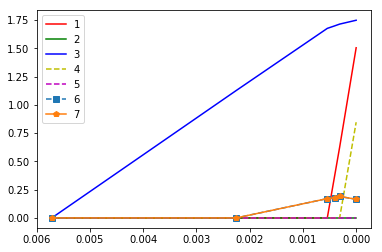

In [33]:
%matplotlib inline
pts, _, all_coeffs = linear_model.lars_path(As[6], bs[6], method="lasso")
plt.plot(pts,all_coeffs[0] , 'r-' , label = '1')
plt.plot(pts,all_coeffs[1] , 'g-' , label = '2')
plt.plot(pts,all_coeffs[2] , 'b-' , label = '3')
plt.plot(pts,all_coeffs[3] , 'y--' , label = '4')
plt.plot(pts,all_coeffs[4] , 'm--' , label = '5')
plt.plot(pts,all_coeffs[5] , 's--' , label = '6')
plt.plot(pts,all_coeffs[5] , 'p-' , label = '7')
plt.gca().invert_xaxis()
plt.legend(loc = "best")


In [36]:
import scipy 

def ls_PQR(A,b,e):
    Q, R , P = scipy.linalg.qr(A, pivoting = True)
    k = next((i for i,x in enumerate(abs(np.diag(R))) if x<e), None)
    k = len(R) if k == None else (k+1)
    Rk = R[:k,:k]
    Qk = Q[:,:k]
    xhat = np.zeros(A.shape[1])
    xhat[P[:k]] = inv(Rk) @ Qk.T @ b
    return xhat

ϵ = 0.00001
for xhat_pqr in [ls_PQR(A, b, 0.00001) for (A, b) in zip(As, bs)]:
    print(xhat_pqr)
    

[ -5.69014225 -16.94664247   7.48609606   3.92937467  11.26258895
  -1.92497794   1.41772384]
[   8.73621514   21.86275592   -5.91191216  -58.4261755  -298.32549213
   59.9650237     1.03032446]
[ 312.62490409  938.03131481 -310.87801448   -6.05486505  -32.15462941
    6.67261714    1.32964679]
[ 1.80925232e+02  5.39727003e+02 -1.78448580e+02  1.10586310e+00
  0.00000000e+00  2.50910714e-01  1.37537227e+00]
[ 1.35166805e+04  4.05473384e+04 -1.35141381e+04  1.96333311e+00
  0.00000000e+00  1.39342001e-01  1.33814056e+00]
[-2.33454653e+05 -7.00368699e+05  2.33457824e+05  8.33236634e-01
  0.00000000e+00  2.04439981e-01  1.34428298e+00]
[-6.09082908e+06 -1.82724918e+07  6.09083233e+06  8.04559028e-01
  0.00000000e+00  1.71238996e-01  1.26111770e+00]
